In [10]:
import os
import shutil
import random
from tqdm import tqdm
original_data_dir = "/kaggle/input/kaggle-cat-vs-dog-dataset/kagglecatsanddogs_3367a/PetImages"
base_dir = "/kaggle/working/cats_and_dogs_split"

train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")

os.makedirs(base_dir, exist_ok=True)
for category in ["Cat", "Dog"]:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(val_dir, category), exist_ok=True)

SPLIT_RATIO = 0.8
for category in ["Cat", "Dog"]:
    src_folder = os.path.join(original_data_dir, category)
    if not os.path.isdir(src_folder):
        print(f"Source directory not found for {category}: {src_folder}")
        continue

    try:
        images = [f for f in os.listdir(src_folder) if os.path.isfile(os.path.join(src_folder, f)) and f.lower().endswith(".jpg")]
        random.shuffle(images)
        split_point = int(len(images) * SPLIT_RATIO)
        train_images = images[:split_point]
        val_images = images[split_point:]

        print(f"Copying {category} images: {len(train_images)} train, {len(val_images)} val")

        for img_name in tqdm(train_images):
            src = os.path.join(src_folder, img_name)
            dst = os.path.join(train_dir, category, img_name)
            try:
                shutil.copy(src, dst)
            except Exception as e:
                print(f"Error copying {src} to {dst}: {e}")
                continue

        for img_name in tqdm(val_images):
            src = os.path.join(src_folder, img_name)
            dst = os.path.join(val_dir, category, img_name)
            try:
                shutil.copy(src, dst)
            except Exception as e:
                print(f"Error copying {src} to {dst}: {e}")
                continue
    except Exception as e:
        print(f"Error listing files in {src_folder}: {e}")
        continue


Copying Cat images: 9992 train, 2498 val


100%|██████████| 2498/2498 [00:22<00:00, 111.87it/s]


Copying Dog images: 9975 train, 2494 val


100%|██████████| 2494/2494 [00:20<00:00, 123.07it/s]


In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    "/kaggle/working/cats_and_dogs_split/train",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    "/kaggle/working/cats_and_dogs_split/val",
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_generator, validation_data=val_generator, epochs=5)


Found 19967 images belonging to 2 classes.
Found 4992 images belonging to 2 classes.
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
359/624 ━━━━━━━━━━━━━━━━━━━━ 5:48 1s/step - accuracy: 0.9516 - loss: 0.1306

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


624/624 ━━━━━━━━━━━━━━━━━━━━ 1019s 2s/step - accuracy: 0.9602 - loss: 0.1079 - val_accuracy: 0.9828 - val_loss: 0.0438
Epoch 2/5
624/624 ━━━━━━━━━━━━━━━━━━━━ 1009s 2s/step - accuracy: 0.9817 - loss: 0.0505 - val_accuracy: 0.9804 - val_loss: 0.0467
Epoch 3/5
624/624 ━━━━━━━━━━━━━━━━━━━━ 1015s 2s/step - accuracy: 0.9829 - loss: 0.0430 - val_accuracy: 0.9834 - val_loss: 0.0403
Epoch 4/5
624/624 ━━━━━━━━━━━━━━━━━━━━ 1007s 2s/step - accuracy: 0.9867 - loss: 0.0350 - val_accuracy: 0.9826 - val_loss: 0.0415
Epoch 5/5
624/624 ━━━━━━━━━━━━━━━━━━━━ 1012s 2s/step - accuracy: 0.9881 - loss: 0.0339 - val_accuracy: 0.9836 - val_loss: 0.0429


156/156 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step
              precision    recall  f1-score   support

         Cat       0.98      0.99      0.98      2498
         Dog       0.99      0.98      0.98      2494

    accuracy                           0.98      4992
   macro avg       0.98      0.98      0.98      4992
weighted avg       0.98      0.98      0.98      4992



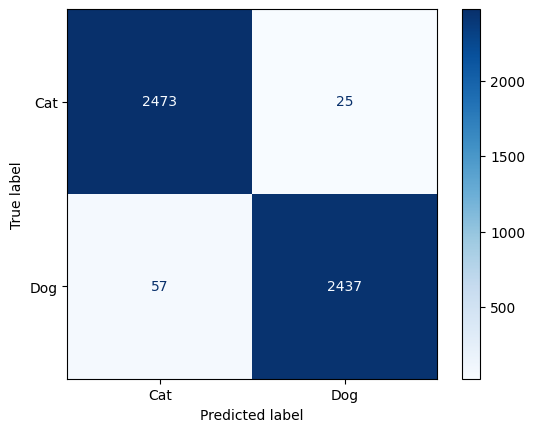

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


val_generator.reset()
preds = model.predict(val_generator)
y_pred = np.round(preds).astype(int).flatten()
y_true = val_generator.classes


print(classification_report(y_true, y_pred, target_names=["Cat", "Dog"]))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Cat", "Dog"])
disp.plot(cmap="Blues")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


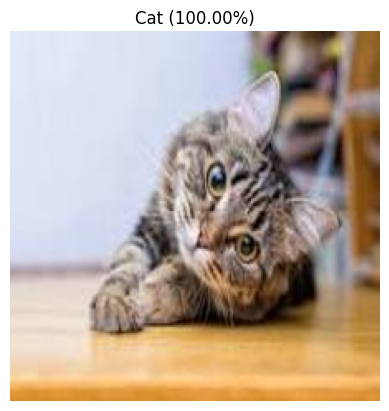

In [13]:
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def predict_image(file_path):
    img = Image.open(file_path).resize((224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)[0][0]
    label = "Dog" if prediction > 0.5 else "Cat"
    confidence = prediction if prediction > 0.5 else 1 - prediction

    plt.imshow(img)
    plt.title(f"{label} ({confidence:.2%})")
    plt.axis('off')
    plt.show()

predict_image("/content/download.jpg")


In [14]:
import gradio as gr
from PIL import Image

# Prediction function
def classify_image(img):
    img = img.resize((224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    prediction = model.predict(img_array)[0][0]
    label = "Dog" if prediction > 0.5 else "Cat"
    confidence = float(prediction if prediction > 0.5 else 1 - prediction)
    return {label: confidence}

# Labels for Gradio interface
labels = ["Cat", "Dog"]

# Create Gradio interface
interface = gr.Interface(
    fn=classify_image,
    inputs=gr.Image(type="pil"),
    outputs=gr.Label(num_top_classes=1),
    title="Cat vs Dog Classifier",
    description="Upload an image to classify it as a cat or a dog using MobileNetV2."
)

# Launch app
interface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ec219df81e981f2c47.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
